In [1]:

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from numpy import mean
import optuna

c:\Users\pzazo\anaconda3\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pzazo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pzazo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocess dataset

In [2]:
regex_pattern = re.compile(r'[^a-zA-Z0-9\s]')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = regex_pattern.sub('', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return filtered_tokens

df = pd.read_csv('bigdata2023classification/train.csv', delimiter=',')
df['Content'] = df['Content'].apply(preprocess_text)

# Fit Tokenizer to learn the vocabulary of the dataset

In [3]:
NUM_WORDS = 10000   # max number of words in the vocabulary

# Tokenize the text and convert it to sequences of integers
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Content'])
sequences = tokenizer.texts_to_sequences(df['Content'])

# Data Generator

In [4]:
def data_generator(data, labels, batch_size, maxlen, tokenizer):
    num_samples = len(data)
        
    while True:
        for offset in range(0, num_samples, batch_size):
            # Get the current batch data and labels
            batch_data = data[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            # Tokenize and pad the batch data
            batch_sequences = tokenizer.texts_to_sequences(batch_data)
            batch_padded_sequences = pad_sequences(batch_sequences, maxlen=maxlen, padding='post', truncating='post')
            
            yield np.array(batch_padded_sequences), np.array(batch_labels)


# Tokenization

Average Sequence Length: 249
Maximum Sequence Length: 8400


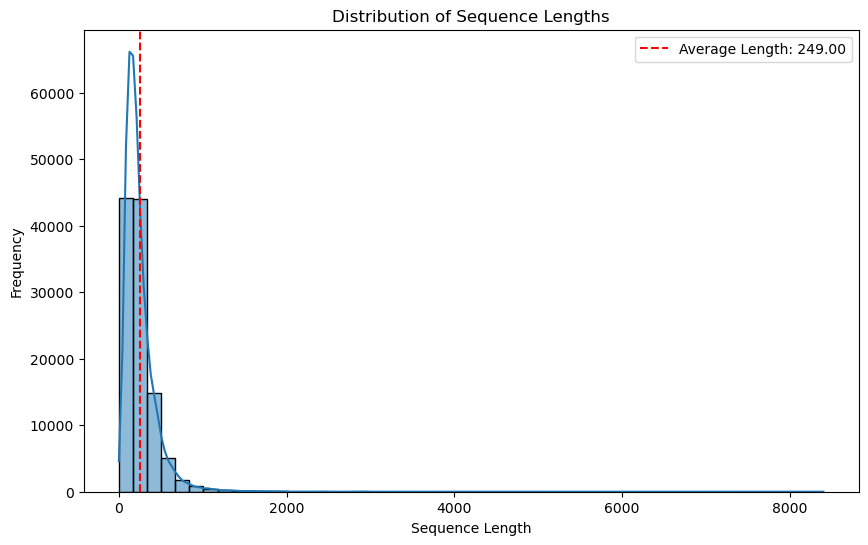

In [5]:
sequence_lengths = [len(x) for x in sequences]

max_seq_length = max(sequence_lengths)
average_length = int(mean(sequence_lengths))

print(f"Average Sequence Length: {average_length}")
print(f"Maximum Sequence Length: {max_seq_length}")

sequence_len = average_length # Average length of the sequences as sequence length for padding and truncating the sequences 

plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=50, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(x=average_length, color='r', linestyle='--', label=f'Average Length: {average_length:.2f}')
plt.legend()
plt.show()

# Label Encoding

In [6]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['Label'])
X_train, X_test, y_train, y_test = train_test_split(df['Content'], integer_encoded, test_size=0.2, random_state=42, stratify=integer_encoded)

In [ ]:
EMBEDDING_DIM = 100

# Define the objective function
def objective(trial):
    # Hyperparameters to optimize
    num_units = trial.suggest_categorical('num_units', [64, 128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    num_lstm_layers = trial.suggest_categorical('num_lstm_layers', [1, 2])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Model construction
    model = Sequential()
    model.add(Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=sequence_len))
    for _ in range(num_lstm_layers):
        model.add(Bidirectional(LSTM(num_units, return_sequences=True if _ < num_lstm_layers - 1 else False)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Splitting the data
    X_train, X_val, y_train, y_val = train_test_split(df['Content'], integer_encoded, test_size=0.2, random_state=42, stratify=integer_encoded)
    
    # Data generators could also be used here, especially for large datasets
    X_train_padded = pad_sequences(X_train, maxlen=sequence_len, padding='post')
    X_val_padded = pad_sequences(X_val, maxlen=sequence_len, padding='post')
    
    # Model training
    history = model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=trial.suggest_categorical('epochs', [10, 20]), batch_size=batch_size, verbose=0)
    
    # Retrieve the best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    return best_val_acc

# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Run the optimization

# Model Structure

In [8]:
EMBEDDING_DIM = 300 
LSTM_UNITS = 128
DROPOUT = 0.2
BATCH_SIZE = 64

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(num_units=128, dropout_rate=0.2, optimizer='adam', num_lstm_layers=1):
    model = Sequential([
        Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=sequence_len),
    ])

    for _ in range(num_lstm_layers):
        model.add(Bidirectional(LSTM(num_units, return_sequences=True)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(num_units, return_sequences=False))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Model Train

In [8]:
train_generator = data_generator(X_train, y_train, BATCH_SIZE, sequence_len, tokenizer)
# ensuring all samples are used for training
steps_per_epoch = np.ceil(len(X_train) / BATCH_SIZE).astype(int)
validation_generator = data_generator(X_test, y_test, BATCH_SIZE, sequence_len, tokenizer)
# ensuring all samples are used for validation
num_test_steps = np.ceil(len(X_test) / BATCH_SIZE).astype(int)

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=num_test_steps,
                    epochs=10)


Epoch 1/10
1398/1398 [==============================] - 175s 115ms/step - loss: 0.6608 - accuracy: 0.7370 - val_loss: 0.2289 - val_accuracy: 0.9299
Epoch 2/10
1398/1398 [==============================] - 154s 110ms/step - loss: 0.1748 - accuracy: 0.9436 - val_loss: 0.1546 - val_accuracy: 0.9496
Epoch 3/10
1398/1398 [==============================] - 154s 110ms/step - loss: 0.1164 - accuracy: 0.9619 - val_loss: 0.1445 - val_accuracy: 0.9559
Epoch 4/10
1398/1398 [==============================] - 153s 110ms/step - loss: 0.0920 - accuracy: 0.9694 - val_loss: 0.1415 - val_accuracy: 0.9564
Epoch 5/10
1398/1398 [==============================] - 155s 111ms/step - loss: 0.0735 - accuracy: 0.9753 - val_loss: 0.1324 - val_accuracy: 0.9597
Epoch 6/10
1398/1398 [==============================] - 195s 140ms/step - loss: 0.0603 - accuracy: 0.9795 - val_loss: 0.1426 - val_accuracy: 0.9588
Epoch 7/10
1398/1398 [==============================] - 157s 112ms/step - loss: 0.0500 - accuracy: 0.9829 - val_